In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from utils.utils_stylegan2 import convert_images_to_uint8

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [3]:
#if cude available set to 'cuda', else, set to 'ref'
impl = 'ref'
gpu = True 

In [4]:
from stylegan2_generator import StyleGan2Generator

### Loading the weights

In [5]:
weights_name = 'ffhq' # face model trained by Nvidia

# instantiating generator network
generator = StyleGan2Generator(weights=weights_name, impl=impl, gpu=gpu)

# loading w average
w_average = np.load('weights/{}_dlatent_avg.npy'.format(weights_name))

Loaded ffhq generator weights!


### Preprocessing functions

In [6]:
import cv2
import PIL
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
def ovalize_new(image):
    faces = detector.detect_faces(image)
    for result in faces:
        x, y, w, h = result['box']
        x1, y1 = x + w, y + h
        image = image[y-75:y1+75, x-75:x1+75]
        break
    mask = np.zeros(image.shape, dtype=np.uint8)
    x,y = image.shape[1], image.shape[0]
    cv2.ellipse(mask, (x//2,y//2), (x//2,y//2),0.0,0.0,360.0,(255,255,255), -1)

    # Bitwise-and for ROI
    ROI = cv2.bitwise_and(image, mask)

    # Crop mask and turn background white
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    x,y,w,h = cv2.boundingRect(mask)
    result = ROI[y:y+h,x:x+w]
    mask = mask[y:y+h,x:x+w]
    result[mask==0] = (255,255,255)
    image = Image.fromarray(result.astype('uint8'), 'RGB')
    fixed_height = 256
    height_percent = (fixed_height / float(image.size[1]))
    width_size = int((float(image.size[0]) * float(height_percent)))
    image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)
    return image

In [7]:
from PIL import Image
def load_image(image_file):
    image_file = Image.fromarray(image_file)
    image_file = image_file.resize((224,224))
    
    return np.array(image_file, dtype=np.uint8)

In [8]:
from PIL import Image
def save_image(image_file,name):
    image_file = Image.fromarray(image_file)
    #image_file = image_file.resize((256,256))
    im1 = image_file.save(name)

### Creating a sample face

(-0.5, 1023.5, 1023.5, -0.5)

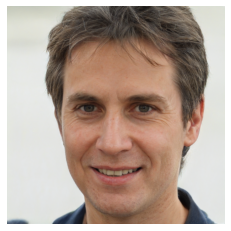

In [9]:
%matplotlib inline
seed = 500
rnd = np.random.RandomState(seed)
z = rnd.randn(1, 512).astype('float32')
#z = np.random.rand(1,512)
dlatents = generator.mapping_network(z)
dlatents = w_average + (dlatents - w_average) * 0.5
out = generator.synthesis_network(dlatents)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

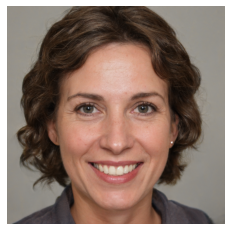

In [10]:
%matplotlib inline
seed = 2000
rnd = np.random.RandomState(seed)
z = rnd.randn(1, 512).astype('float32')
#z = np.random.rand(1,512)
dlatents = generator.mapping_network(z)
dlatents = w_average + (dlatents - w_average) * 0.5
out = generator.synthesis_network(dlatents)
img1= convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img1 = img1.numpy()[0]
#img = load_image(img)
plt.imshow(img1)
plt.axis('off')

### Loading the assessors

In [11]:
import numpy as np
from PIL import Image
from cv2 import resize
import tensorflow as tf
import multiprocessing as mp
import pandas as pd
#import matplotlib.pyplot as plt
import os
#import seaborn as sns
import csv
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from tensorflow.keras.models import Model, Sequential



def euclidean_distance_loss(y_true, y_pred):
    return tf.math.sqrt(tf.math.reduce_sum(tf.math.square(y_pred - y_true), axis=-1))

assessor_1 = tf.keras.models.load_model('assessors/face/resnet/epoch_28.h5', custom_objects={'euclidean_distance_loss': euclidean_distance_loss})
assessor_2 = tf.keras.models.load_model('assessors/face/senet/epoch_19.h5', custom_objects={'euclidean_distance_loss': euclidean_distance_loss})
assessor_3 = tf.keras.models.load_model('assessors/face/vgg/vgg_epoch_18.h5', custom_objects={'euclidean_distance_loss': euclidean_distance_loss})

### A sample for ovalization

(-0.5, 201.5, 255.5, -0.5)

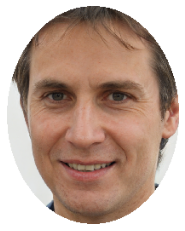

In [12]:
oval = ovalize_new(img)
oval = np.array(oval)
plt.imshow(oval)
plt.axis('off')

(-0.5, 191.5, 255.5, -0.5)

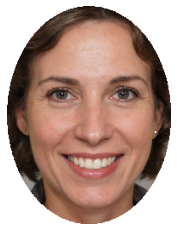

In [13]:
oval = ovalize_new(img1)
oval = np.array(oval)
plt.imshow(oval)
plt.axis('off')

### Getting the memorability scores of a sample face

In [14]:
oval = load_image(oval)
oval = oval.reshape((1,224,224,3))
print(assessor_1.predict(oval))
print(assessor_2.predict(oval))
print(assessor_3.predict(oval))

[[0.25346622]]
[[0.17683624]]
[[0.26568598]]


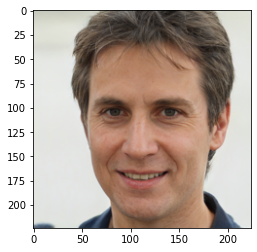

In [15]:
img = load_image(img)
plt.imshow(img)

In [16]:
img = img.reshape((1,224,224,3))
print(assessor_1.predict(img)[0])
print(assessor_2.predict(img)[0])
print(assessor_3.predict(img)[0])

[0.4790257]
[0.5968414]
[0.22343974]


### Creating the dataset (You can skip this section and load the dataset from next section)

In [19]:
mems_1 = []
mems_2 = []
mems_3 = []

mems_1_oval = []
mems_2_oval = []
mems_3_oval = []

In [18]:
lats = []

In [ ]:
for i in range(100000):
    rnd = np.random.RandomState(i)
    z = rnd.randn(1, 512).astype('float32')
    lats.append(z)
    dlatents = generator.mapping_network(z)
    dlatents = w_average + (dlatents - w_average) * 0.5

    out = generator.synthesis_network(dlatents)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    #save_image(img,file_path_sq+str(i)+'.png')
    oval = ovalize_new(img)
    oval = np.array(oval)
    #save_image(oval,file_path_ov+str(i)+'.png')
    oval = load_image(oval)
    oval = oval.reshape((1,224,224,3))

    mems_1_oval.append(assessor_1.predict(oval)[0])
    mems_2_oval.append(assessor_2.predict(oval)[0])
    mems_3_oval.append(assessor_3.predict(oval)[0])

    img = load_image(img)
    img = img.reshape((1,224,224,3))

    mems_1.append(assessor_1.predict(img)[0])
    mems_2.append(assessor_2.predict(img)[0])
    mems_3.append(assessor_3.predict(img)[0])

    if i%1000 == 0:
        print(i)

In [320]:
np.save('mems_resnet.npy', mems_1)
np.save('mems_senet.npy', mems_2)
np.save('mems_vgg.npy', mems_3)
np.save('mems_resnet_oval.npy', mems_1_oval)
np.save('mems_senet_oval.npy', mems_2_oval)
np.save('mems_vgg_oval.npy', mems_3_oval)
np.save('lats_512_style2.npy', lats)

### Loading the memorability values and latent vectors

In [20]:
mems_1 = np.load('mems_resnet.npy')
mems_1_oval = np.load('mems_resnet_oval.npy')
mems_2 = np.load('mems_senet.npy')
mems_2_oval = np.load('mems_senet_oval.npy')
mems_3 = np.load('mems_vgg.npy')
mems_3_oval = np.load('mems_vgg_oval.npy')

lats = np.load('lats_512_style2.npy')

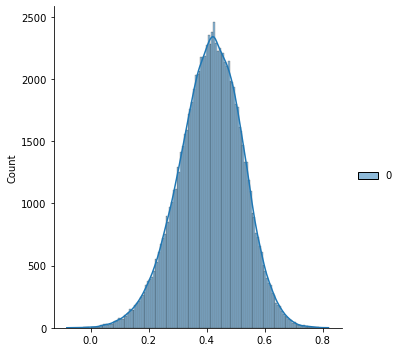

In [28]:
import seaborn as sns

sns.displot(mems_1,kde = True)

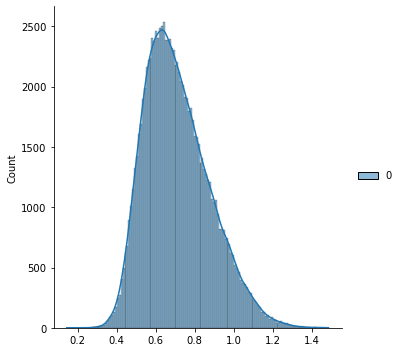

In [29]:
sns.displot(mems_2,kde = True)

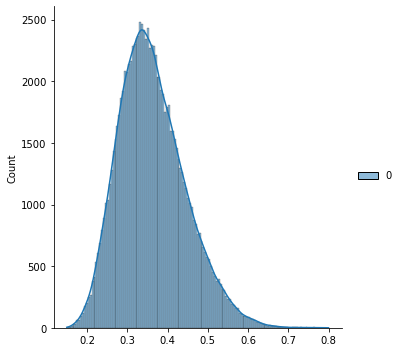

In [30]:
sns.displot(mems_3,kde = True)

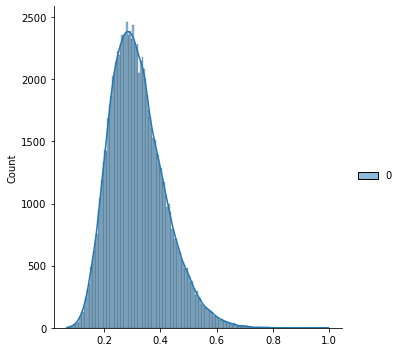

In [31]:
sns.displot(mems_1_oval,kde = True)

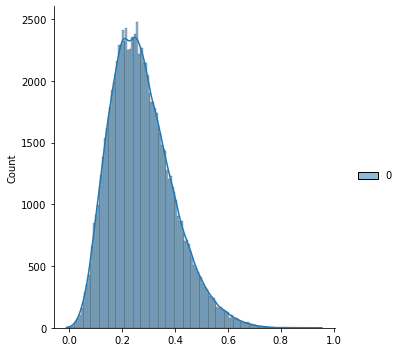

In [32]:
sns.displot(mems_2_oval,kde = True)

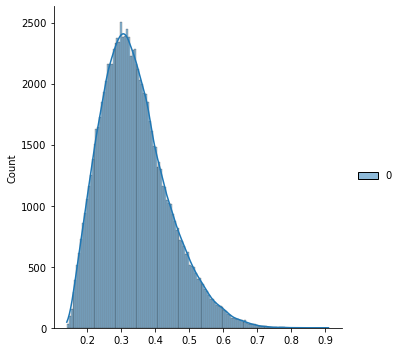

In [33]:
sns.displot(mems_3_oval,kde = True)

### Saving and loading the extended latent vector of each image

In [328]:
mems_aug_style2 = [(w_average + (generator.mapping_network(x) - w_average) * 0.5) for x in lats]

In [ ]:
np.save('lats_aug_style2.npy', mems_aug_style2)

In [34]:
mems_aug_style2 = np.load('lats_aug_style2.npy')

In [35]:
print(mems_aug_style2.shape)

(100000, 1, 18, 512)


### Getting the rank correlation of the oval and square-shaped memorability scores

In [36]:
from scipy.stats import rankdata

rank_1 = rankdata(mems_1)
rank_2 = rankdata(mems_2)
rank_3 = rankdata(mems_3)
rank_1_oval = rankdata(mems_1_oval)
rank_2_oval = rankdata(mems_2_oval)
rank_3_oval = rankdata(mems_3_oval)

In [37]:
from scipy import stats

sp1 = stats.spearmanr(rank_1, rank_1_oval)
sp2 = stats.spearmanr(rank_2, rank_2_oval)
sp3 = stats.spearmanr(rank_3, rank_3_oval)
kt1 = stats.kendalltau(rank_1, rank_1_oval)
kt2 = stats.kendalltau(rank_2, rank_2_oval)
kt3 = stats.kendalltau(rank_3, rank_3_oval)

print("SP and kt for the first assessor: ")
print(sp1)
print(kt1)
print("SP and kt for the second assessor: ")
print(sp2)
print(kt2)
print("SP and kt for the third assessor: ")
print(sp3)
print(kt3)

SP and kt for the first assessor: 
SpearmanrResult(correlation=0.23913553336200516, pvalue=0.0)
KendalltauResult(correlation=0.16066774256245728, pvalue=0.0)
SP and kt for the second assessor: 
SpearmanrResult(correlation=0.6217577943196705, pvalue=0.0)
KendalltauResult(correlation=0.44192398487816204, pvalue=0.0)
SP and kt for the third assessor: 
SpearmanrResult(correlation=0.6562532862594502, pvalue=0.0)
KendalltauResult(correlation=0.47204200348886305, pvalue=0.0)


### Labeling the images to highly-memorable and low memorable faces

In [38]:
#You can use mean or median

mean_1 = np.mean(mems_1) 
mean_2 = np.mean(mems_2)
mean_3 = np.mean(mems_3)
mean_1_oval = np.mean(mems_1_oval)
mean_2_oval = np.mean(mems_2_oval)
mean_3_oval = np.mean(mems_3_oval)

In [39]:
y_1 = np.ones_like(mems_1)
y_1[mems_1<mean_1] = 0
y_2 = np.ones_like(mems_2)
y_2[mems_2<mean_2] = 0
y_3 = np.ones_like(mems_3)
y_3[mems_3<mean_3] = 0
y_1_oval = np.ones_like(mems_1_oval)
y_1_oval[mems_1_oval<mean_1_oval] = 0
y_2_oval = np.ones_like(mems_2_oval)
y_2_oval[mems_2_oval<mean_2_oval] = 0
y_3_oval = np.ones_like(mems_3_oval)
y_3_oval[mems_3_oval<mean_3_oval] = 0

In [17]:
lats = lats.reshape((100000,512))
print(lats.shape)

(100000, 512)


In [15]:
mems_aug_style2 = np.array([np.ravel(x) for x in mems_aug_style2])
print(mems_aug_style2.shape)

(100000, 9216)


### Layer-wise analysis

In [15]:
work = mems_aug_style2[:10000]
work_mem = mems_2[:10000]
work_mem_oval = mems_2_oval[:2500]

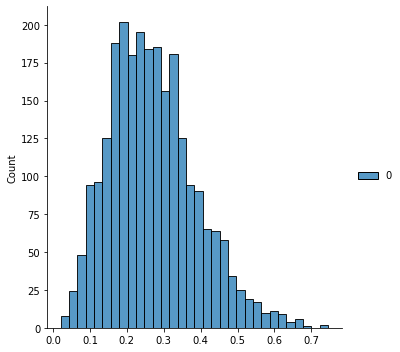

In [15]:
sns.displot(work_mem_oval)

In [41]:
#Linear-shifting of the memorability to make the mean and std equal to the 10k us face database for square-shaped faces

def calc_mem(x):
    a = (x-0.71059185)*(0.15/0.16659632) + 0.4
    if a>1:
        a = 1
    if a<0:
        a= 0
    return a

In [51]:
#Linear-shifting of the memorability to make the mean and std equal to the 10k us face database for oval-shaped faces

def calc_mem_ov(x):
    a = (x-0.273)*(0.138/0.117) + 0.38
    if a>1:
        a = 1
    if a<0:
        a= 0
    return a

In [ ]:
work_mem = np.array([calc_mem(x) for x in work_mem])
work_mem = np.ravel(work_mem)
work_mem = work_mem.astype('float32')

In [274]:
work_mem_oval = np.array([calc_mem_ov(x) for x in work_mem_oval])
work_mem_oval = np.ravel(work_mem_oval)
work_mem_oval = work_mem_oval.astype('float32')

In [42]:
#Loading the separating hyperplane based on SENET assessor

w_sq = np.load('w_aug_ass2_sq_mean.npy')
w_ov = np.load('w_aug_ass2_ov_mean.npy')

w_sq = w_sq/np.linalg.norm(w_sq)
w_ov = w_ov/np.linalg.norm(w_ov)

[0.3146646]


(-0.5, 1023.5, 1023.5, -0.5)

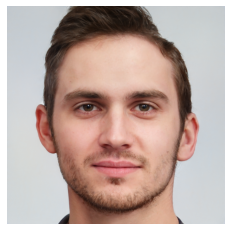

In [48]:
%matplotlib inline
j = 1  #j is the layer
x = work[505].copy()
x[512*j:(j+1)*512] = x[512*j:(j+1)*512] -220* w_sq[512*j:(j+1)*512]
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
ov = load_image(img)
ov = ov.reshape((1,224,224,3))

x = assessor_2.predict(ov)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

[0.25473678]


(-0.5, 206.5, 255.5, -0.5)

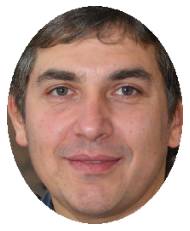

In [872]:
j = 1
x = work[73].copy()
x[512*j:(j+1)*512] = x[512*j:(j+1)*512] -140* w_ov[512*j:(j+1)*512]
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
ov = load_image(oval)
ov = ov.reshape((1,224,224,3))

x = assessor_2.predict(ov)[0]
print(calc_mem_ov(x))
plt.imshow(oval)
plt.axis('off')

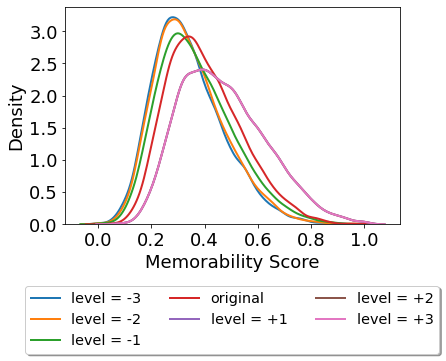

In [828]:
import seaborn as sns

#plt.figure(figsize=(12,8))
b = sns.kdeplot(sq_layer_2_neg_3, label = 'level = -3',linewidth=2)
b =sns.kdeplot(sq_layer_2_neg_2, label = 'level = -2',linewidth=2)
b =sns.kdeplot(sq_layer_2_neg_1, label = 'level = -1',linewidth=2)
b =sns.kdeplot(work_mem,label = 'original',linewidth=2)
b =sns.kdeplot(sq_layer_2_pos_1, label = 'level = +1',linewidth=2)
b =sns.kdeplot(sq_layer_2_pos_2, label = 'level = +2',linewidth=2)
b =sns.kdeplot(sq_layer_2_pos_3, label = 'level = +3',linewidth=2)

b.set_xlabel("Memorability Score",fontsize=18)
b.set_ylabel("Density",fontsize=18)
#b.tick_params(labelsize=0.5)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),fontsize='x-large'
          ,fancybox=True, shadow=True, ncol=3)
#plt.legend(fontsize='x-large',ncol=1)
#plt.savefig('mem_ov_dist_ff.png')
plt.show()


#plt.show()



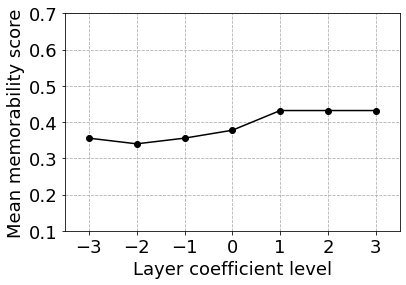

In [838]:
plt.plot([-3,-2,-1,0,1,2,3], [mean_neg_3,mean_neg_2,mean_neg_1,mean_org,mean_pos_1,mean_pos_2,mean_pos_3],marker='o',color='black')

plt.xlabel('Layer coefficient level',fontsize=18)
plt.xlim((-3.5,+3.5))
plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean memorability score',fontsize=18)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

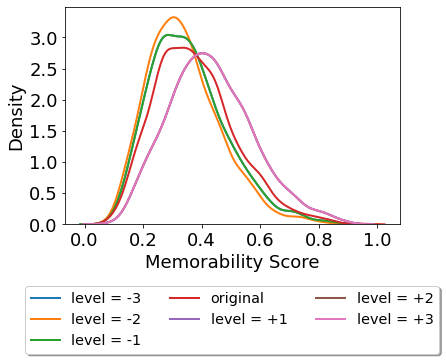

In [837]:
import seaborn as sns

#plt.figure(figsize=(12,8))
b =sns.kdeplot(ov_layer_2_neg_3, label = 'level = -3',linewidth=2)
b =sns.kdeplot(ov_layer_2_neg_2, label = 'level = -2',linewidth=2)
b =sns.kdeplot(ov_layer_2_neg_1, label = 'level = -1',linewidth=2)
b =sns.kdeplot(work_mem_oval,label = 'original',linewidth=2)
b =sns.kdeplot(ov_layer_2_pos_1, label = 'level = +1',linewidth=2)
b =sns.kdeplot(ov_layer_2_pos_2, label = 'level = +2',linewidth=2)
b =sns.kdeplot(ov_layer_2_pos_3, label = 'level = +3',linewidth=2)



#plt.ylabel("Density")
#plt.legend(loc='upper right')
#plt.title("Shifted Memorability VGG_Face (H-F)")
#plt.savefig("hist_test_1_kde.png")
#y = np.array([0,1,2,3,4,5])

#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Memorability Score",fontsize=18)
b.set_ylabel("Density",fontsize=18)
#b.tick_params(labelsize=0.5)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),fontsize='x-large'
          ,fancybox=True, shadow=True, ncol=3)
#plt.legend(fontsize='x-large',ncol=1)
#plt.savefig('mem_ov_dist_ff.png')
plt.show()


#plt.show()



#### Loading different layers (before and after memorability modification)

In [825]:
sq_layer_2_neg_3 = np.load('sq_layer_2_neg_3.npy')
sq_layer_2_neg_2 = np.load('sq_layer_2_neg_2.npy')
sq_layer_2_neg_1 = np.load('sq_layer_2_neg_1.npy')
sq_layer_2_pos_1 = np.load('sq_layer_2_pos_1.npy')
sq_layer_2_pos_2 = np.load('sq_layer_2_pos_2.npy')
sq_layer_2_pos_3 = np.load('sq_layer_2_pos_3.npy')

In [ ]:
sq_layer_2_neg_3 = np.array([calc_mem(x) for x in sq_layer_2_neg_3],dtype='float32')
sq_layer_2_neg_2 = np.array([calc_mem(x) for x in sq_layer_2_neg_2],dtype='float32')
sq_layer_2_neg_1 = np.array([calc_mem(x) for x in sq_layer_2_neg_1],dtype='float32')
sq_layer_2_pos_1 = np.array([calc_mem(x) for x in sq_layer_2_pos_1],dtype='float32')
sq_layer_2_pos_2 = np.array([calc_mem(x) for x in sq_layer_2_pos_2],dtype='float32')
sq_layer_2_pos_3 = np.array([calc_mem(x) for x in sq_layer_2_pos_3],dtype='float32')

sq_layer_2_neg_3 = np.ravel(sq_layer_2_neg_3)
sq_layer_2_neg_2 = np.ravel(sq_layer_2_neg_2)
sq_layer_2_neg_1 = np.ravel(sq_layer_2_neg_1)
sq_layer_2_pos_1 = np.ravel(sq_layer_2_pos_3)
sq_layer_2_pos_2 = np.ravel(sq_layer_2_pos_3)
sq_layer_2_pos_3 = np.ravel(sq_layer_2_pos_3)

In [827]:
mean_neg_3 = np.mean(sq_layer_2_neg_3)
mean_neg_2 = np.mean(sq_layer_2_neg_2)
mean_neg_1 = np.mean(sq_layer_2_neg_1)
mean_org = np.mean(work_mem)
mean_pos_1 = np.mean(sq_layer_2_pos_1)
mean_pos_2 = np.mean(sq_layer_2_pos_2)
mean_pos_3 = np.mean(sq_layer_2_pos_3)

In [834]:
ov_layer_2_neg_3 = np.load('ov_layer_2_neg_1.npy')
ov_layer_2_neg_2 = np.load('ov_layer_2_neg_2.npy')
ov_layer_2_neg_1 = np.load('ov_layer_2_neg_1.npy')
ov_layer_2_pos_1 = np.load('ov_layer_2_pos_1.npy')
ov_layer_2_pos_2 = np.load('ov_layer_2_pos_2.npy')
ov_layer_2_pos_3 = np.load('ov_layer_2_pos_3.npy')

In [835]:
ov_layer_2_neg_3 = np.array([calc_mem_ov(x) for x in ov_layer_2_neg_3],dtype='float32')
ov_layer_2_neg_2 = np.array([calc_mem_ov(x) for x in ov_layer_2_neg_2],dtype='float32')
ov_layer_2_neg_1 = np.array([calc_mem_ov(x) for x in ov_layer_2_neg_1],dtype='float32')
ov_layer_2_pos_1 = np.array([calc_mem_ov(x) for x in ov_layer_2_pos_1],dtype='float32')
ov_layer_2_pos_2 = np.array([calc_mem_ov(x) for x in ov_layer_2_pos_2],dtype='float32')
ov_layer_2_pos_3 = np.array([calc_mem_ov(x) for x in ov_layer_2_pos_3],dtype='float32')

ov_layer_2_neg_3 = np.ravel(ov_layer_2_neg_3)
ov_layer_2_neg_2 = np.ravel(ov_layer_2_neg_2)
ov_layer_2_neg_1 = np.ravel(ov_layer_2_neg_1)
ov_layer_2_pos_1 = np.ravel(ov_layer_2_pos_3)
ov_layer_2_pos_2 = np.ravel(ov_layer_2_pos_3)
ov_layer_2_pos_3 = np.ravel(ov_layer_2_pos_3)

In [836]:
mean_neg_3 = np.mean(ov_layer_2_neg_3)
mean_neg_2 = np.mean(ov_layer_2_neg_2)
mean_neg_1 = np.mean(ov_layer_2_neg_1)
mean_org = np.mean(work_mem_oval)
mean_pos_1 = np.mean(ov_layer_2_pos_1)
mean_pos_2 = np.mean(ov_layer_2_pos_2)
mean_pos_3 = np.mean(ov_layer_2_pos_3)

In [728]:
ov_layer_10_neg_1 = []
ov_layer_10_neg_2 = []
ov_layer_10_neg_3 = []
ov_layer_10_pos_1 = []
ov_layer_10_pos_2 = []
ov_layer_10_pos_3 = []

In [337]:
w_ov.shape

(9216,)

In [729]:
j = 9
for i in range(2500):
    x = work[i].copy()
    x[512*j:(j+1)*512] = x[512*j:(j+1)*512] + 20 * w_ov[512*j:(j+1)*512]
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    oval = ovalize_new(img)
    oval = np.array(oval)
    ov = load_image(oval)
    ov = ov.reshape((1,224,224,3))
    ov_layer_10_pos_1.append(assessor_2.predict(ov)[0])
    
    x = work[i].copy()
    x[512*j:(j+1)*512] = x[512*j:(j+1)*512] + 40 * w_ov[512*j:(j+1)*512]
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    oval = ovalize_new(img)
    oval = np.array(oval)
    ov = load_image(oval)
    ov = ov.reshape((1,224,224,3))
    ov_layer_10_pos_2.append(assessor_2.predict(ov)[0])
    
    x = work[i].copy()
    x[512*j:(j+1)*512] = x[512*j:(j+1)*512] + 60 * w_ov[512*j:(j+1)*512]
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    oval = ovalize_new(img)
    oval = np.array(oval)
    ov = load_image(oval)
    ov = ov.reshape((1,224,224,3))
    ov_layer_10_pos_3.append(assessor_2.predict(ov)[0])
    
    x = work[i].copy()
    x[512*j:(j+1)*512] = x[512*j:(j+1)*512] - 15 * w_ov[512*j:(j+1)*512]
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    oval = ovalize_new(img)
    oval = np.array(oval)
    ov = load_image(oval)
    ov = ov.reshape((1,224,224,3))
    ov_layer_10_neg_1.append(assessor_2.predict(ov)[0])
    
    x = work[i].copy()
    x[512*j:(j+1)*512] = x[512*j:(j+1)*512] - 30 * w_ov[512*j:(j+1)*512]
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    oval = ovalize_new(img)
    oval = np.array(oval)
    ov = load_image(oval)
    ov = ov.reshape((1,224,224,3))
    ov_layer_10_neg_2.append(assessor_2.predict(ov)[0])
    
    x = work[i].copy()
    x[512*j:(j+1)*512] = x[512*j:(j+1)*512] - 45 * w_ov[512*j:(j+1)*512]
    x = x.reshape((1,18,512))
    out = generator.synthesis_network(x)
    img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
    img = img.numpy()[0]
    oval = ovalize_new(img)
    oval = np.array(oval)
    ov = load_image(oval)
    ov = ov.reshape((1,224,224,3))
    ov_layer_10_neg_3.append(assessor_2.predict(ov)[0])
    
    if i%100==0:
        print(i/100)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0


In [ ]:
sns.distplot(mem_neg_sq_7, label = 'coeff = -7')
sns.distplot(mem_neg_sq_4, label = 'coeff = -4')
sns.distplot(mem_neg_sq_2, label = 'coeff = -2')
sns.distplot(mems_2[:10000],label = 'original')
sns.distplot(mem_pos_sq_2, label = 'coeff = +2')
sns.distplot(mem_pos_sq_4, label = 'coeff = +4')
sns.distplot(mem_pos_sq_7, label = 'coeff = +7')

plt.legend()
plt.show()

In [110]:
np.save('mem_neg_ov_3.npy', mem_neg_ov_3)
np.save('mem_neg_ov_6.npy', mem_neg_ov_6)
np.save('mem_neg_ov_9.npy', mem_neg_ov_9)
np.save('mem_pos_ov_3.npy', mem_pos_ov_3)
np.save('mem_pos_ov_6.npy', mem_pos_ov_6)
np.save('mem_pos_ov_9.npy', mem_pos_ov_9)

In [ ]:
sns.distplot(mem_neg_ov_9, label = 'coeff = -9')
sns.distplot(mem_neg_ov_6, label = 'coeff = -6')
sns.distplot(mem_neg_ov_3, label = 'coeff = -3')
sns.distplot(work_mem_oval[:10000],label = 'original')
sns.distplot(mem_pos_ov_3, label = 'coeff = +3')
sns.distplot(mem_pos_ov_6, label = 'coeff = +6')
sns.distplot(mem_pos_ov_9, label = 'coeff = +9')

plt.legend()
plt.show()

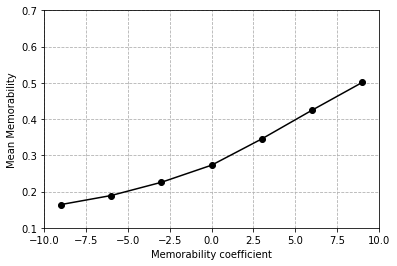

In [109]:
plt.plot([-9,-6,-3,0,3,6,9], [np.mean(mem_neg_ov_9),np.mean(mem_neg_ov_6),np.mean(mem_neg_ov_3),np.mean(work_mem_oval[:10000]),np.mean(mem_pos_ov_3),np.mean(mem_pos_ov_6),np.mean(mem_pos_ov_9)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-10,+10))
plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

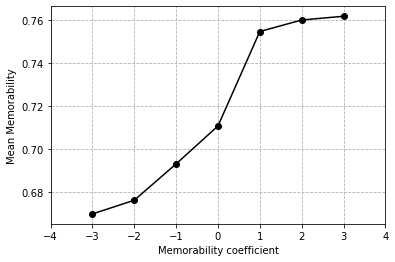

In [32]:
#layer_1

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_1_neg_3),np.mean(sq_layer_1_neg_2),np.mean(sq_layer_1_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_1_pos_1),np.mean(sq_layer_1_pos_2),np.mean(sq_layer_1_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

print(np.std())

In [33]:
print(np.std(sq_layer_1_neg_3))
print(np.std(sq_layer_1_neg_2))
print(np.std(sq_layer_1_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_1_pos_1))
print(np.std(sq_layer_1_pos_2))
print(np.std(sq_layer_1_pos_3))

0.16095273
0.16260573
0.1650227
0.16730599
0.1718411
0.1731581
0.17395988


In [34]:
np.save('sq_layer_1_neg_3.npy',sq_layer_1_neg_3)
np.save('sq_layer_1_neg_2.npy',sq_layer_1_neg_2)
np.save('sq_layer_1_neg_1.npy',sq_layer_1_neg_1)
np.save('sq_layer_1_pos_1.npy',sq_layer_1_pos_1)
np.save('sq_layer_1_pos_2.npy',sq_layer_1_pos_2)
np.save('sq_layer_1_pos_3.npy',sq_layer_1_pos_3)

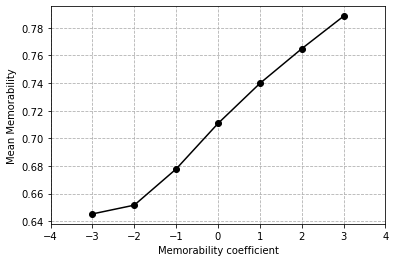

In [68]:
#layer_2

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_2_neg_3),np.mean(sq_layer_2_neg_2),np.mean(sq_layer_2_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_2_pos_1),np.mean(sq_layer_2_pos_2),np.mean(sq_layer_2_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [69]:
print(np.std(sq_layer_2_neg_3))
print(np.std(sq_layer_2_neg_2))
print(np.std(sq_layer_2_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_2_pos_1))
print(np.std(sq_layer_2_pos_2))
print(np.std(sq_layer_2_pos_3))

0.14861268
0.1491636
0.15810008
0.16730599
0.17234626
0.17610253
0.17874527


In [70]:
np.save('sq_layer_2_neg_3.npy',sq_layer_2_neg_3)
np.save('sq_layer_2_neg_2.npy',sq_layer_2_neg_2)
np.save('sq_layer_2_neg_1.npy',sq_layer_2_neg_1)
np.save('sq_layer_2_pos_1.npy',sq_layer_2_pos_1)
np.save('sq_layer_2_pos_2.npy',sq_layer_2_pos_2)
np.save('sq_layer_2_pos_3.npy',sq_layer_2_pos_3)

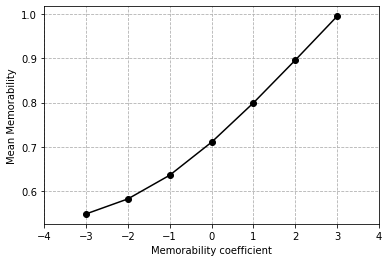

In [89]:
#layer_3

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_3_neg_3),np.mean(sq_layer_3_neg_2),np.mean(sq_layer_3_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_3_pos_1),np.mean(sq_layer_3_pos_2),np.mean(sq_layer_3_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [90]:
print(np.std(sq_layer_3_neg_3))
print(np.std(sq_layer_3_neg_2))
print(np.std(sq_layer_3_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_3_pos_1))
print(np.std(sq_layer_3_pos_2))
print(np.std(sq_layer_3_pos_3))

0.13962626
0.14594476
0.15493639
0.16730599
0.18008444
0.19159779
0.20183374


In [91]:
np.save('sq_layer_3_neg_3.npy',sq_layer_3_neg_3)
np.save('sq_layer_3_neg_2.npy',sq_layer_3_neg_2)
np.save('sq_layer_3_neg_1.npy',sq_layer_3_neg_1)
np.save('sq_layer_3_pos_1.npy',sq_layer_3_pos_1)
np.save('sq_layer_3_pos_2.npy',sq_layer_3_pos_2)
np.save('sq_layer_3_pos_3.npy',sq_layer_3_pos_3)

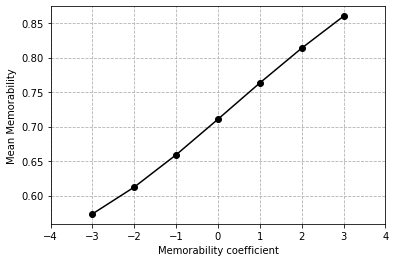

In [116]:
#layer_4

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_4_neg_3),np.mean(sq_layer_4_neg_2),np.mean(sq_layer_4_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_4_pos_1),np.mean(sq_layer_4_pos_2),np.mean(sq_layer_4_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [117]:
print(np.std(sq_layer_4_neg_3))
print(np.std(sq_layer_4_neg_2))
print(np.std(sq_layer_4_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_4_pos_1))
print(np.std(sq_layer_4_pos_2))
print(np.std(sq_layer_4_pos_3))

0.14183444
0.14994408
0.15941459
0.16730599
0.17302123
0.17790964
0.18060759


In [118]:
np.save('sq_layer_4_neg_3.npy',sq_layer_4_neg_3)
np.save('sq_layer_4_neg_2.npy',sq_layer_4_neg_2)
np.save('sq_layer_4_neg_1.npy',sq_layer_4_neg_1)
np.save('sq_layer_4_pos_1.npy',sq_layer_4_pos_1)
np.save('sq_layer_4_pos_2.npy',sq_layer_4_pos_2)
np.save('sq_layer_4_pos_3.npy',sq_layer_4_pos_3)

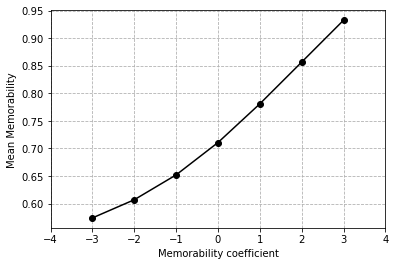

In [143]:
#layer_5

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_5_neg_3),np.mean(sq_layer_5_neg_2),np.mean(sq_layer_5_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_5_pos_1),np.mean(sq_layer_5_pos_2),np.mean(sq_layer_5_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [144]:
print(np.std(sq_layer_5_neg_3))
print(np.std(sq_layer_5_neg_2))
print(np.std(sq_layer_5_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_5_pos_1))
print(np.std(sq_layer_5_pos_2))
print(np.std(sq_layer_5_pos_3))

0.13890718
0.14689219
0.15596622
0.16730599
0.17875725
0.18996553
0.19831398


In [145]:
np.save('sq_layer_5_neg_3.npy',sq_layer_5_neg_3)
np.save('sq_layer_5_neg_2.npy',sq_layer_5_neg_2)
np.save('sq_layer_5_neg_1.npy',sq_layer_5_neg_1)
np.save('sq_layer_5_pos_1.npy',sq_layer_5_pos_1)
np.save('sq_layer_5_pos_2.npy',sq_layer_5_pos_2)
np.save('sq_layer_5_pos_3.npy',sq_layer_5_pos_3)

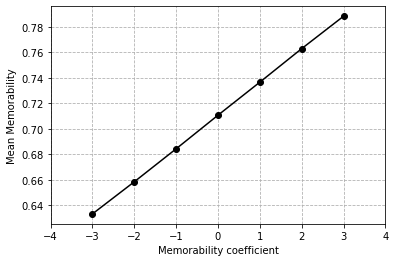

In [161]:
#layer_6

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_6_neg_3),np.mean(sq_layer_6_neg_2),np.mean(sq_layer_6_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_6_pos_1),np.mean(sq_layer_6_pos_2),np.mean(sq_layer_6_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [160]:
print(np.std(sq_layer_6_neg_3))
print(np.std(sq_layer_6_neg_2))
print(np.std(sq_layer_6_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_6_pos_1))
print(np.std(sq_layer_6_pos_2))
print(np.std(sq_layer_6_pos_3))

0.15487105
0.1591981
0.16346721
0.16730599
0.17051914
0.17369673
0.17644918


In [162]:
np.save('sq_layer_6_neg_3.npy',sq_layer_6_neg_3)
np.save('sq_layer_6_neg_2.npy',sq_layer_6_neg_2)
np.save('sq_layer_6_neg_1.npy',sq_layer_6_neg_1)
np.save('sq_layer_6_pos_1.npy',sq_layer_6_pos_1)
np.save('sq_layer_6_pos_2.npy',sq_layer_6_pos_2)
np.save('sq_layer_6_pos_3.npy',sq_layer_6_pos_3)

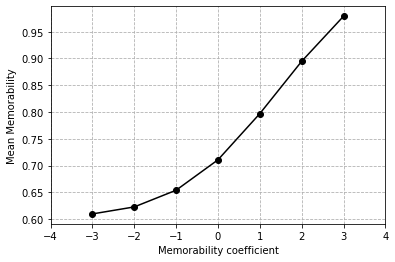

In [183]:
#layer_7

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_7_neg_3),np.mean(sq_layer_7_neg_2),np.mean(sq_layer_7_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_7_pos_1),np.mean(sq_layer_7_pos_2),np.mean(sq_layer_7_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [184]:
print(np.std(sq_layer_7_neg_3))
print(np.std(sq_layer_7_neg_2))
print(np.std(sq_layer_7_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_7_pos_1))
print(np.std(sq_layer_7_pos_2))
print(np.std(sq_layer_7_pos_3))

0.13461752
0.13841404
0.14932789
0.16730599
0.18089731
0.17853376
0.17184867


In [185]:
np.save('sq_layer_7_neg_3.npy',sq_layer_7_neg_3)
np.save('sq_layer_7_neg_2.npy',sq_layer_7_neg_2)
np.save('sq_layer_7_neg_1.npy',sq_layer_7_neg_1)
np.save('sq_layer_7_pos_1.npy',sq_layer_7_pos_1)
np.save('sq_layer_7_pos_2.npy',sq_layer_7_pos_2)
np.save('sq_layer_7_pos_3.npy',sq_layer_7_pos_3)

In [52]:
sq_layer_8_neg_3 = np.load('sq_layer_8_neg_3.npy')
sq_layer_8_neg_2 = np.load('sq_layer_8_neg_2.npy')
sq_layer_8_neg_1 = np.load('sq_layer_8_neg_1.npy')
sq_layer_8_pos_1 = np.load('sq_layer_8_pos_1.npy')
sq_layer_8_pos_2 = np.load('sq_layer_8_pos_2.npy')
sq_layer_8_pos_3 = np.load('sq_layer_8_pos_3.npy')

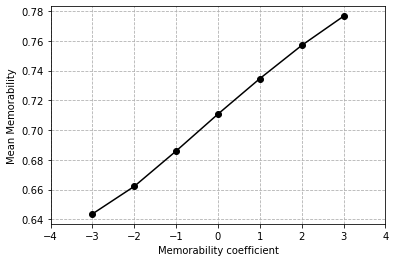

In [53]:
#layer_8

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_8_neg_3),np.mean(sq_layer_8_neg_2),np.mean(sq_layer_8_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_8_pos_1),np.mean(sq_layer_8_pos_2),np.mean(sq_layer_8_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [54]:
print(np.std(sq_layer_8_neg_3))
print(np.std(sq_layer_8_neg_2))
print(np.std(sq_layer_8_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_8_pos_1))
print(np.std(sq_layer_8_pos_2))
print(np.std(sq_layer_8_pos_3))

0.14841424
0.15546937
0.16245434
0.16730599
0.1698905
0.17116974
0.17092635


In [ ]:
np.save('sq_layer_8_neg_3.npy',sq_layer_8_neg_3)
np.save('sq_layer_8_neg_2.npy',sq_layer_8_neg_2)
np.save('sq_layer_8_neg_1.npy',sq_layer_8_neg_1)
np.save('sq_layer_8_pos_1.npy',sq_layer_8_pos_1)
np.save('sq_layer_8_pos_2.npy',sq_layer_8_pos_2)
np.save('sq_layer_8_pos_3.npy',sq_layer_8_pos_3)

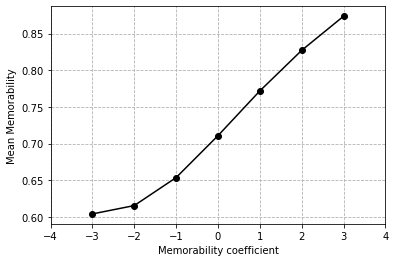

In [49]:
#layer_9

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_9_neg_3),np.mean(sq_layer_9_neg_2),np.mean(sq_layer_9_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_9_pos_1),np.mean(sq_layer_9_pos_2),np.mean(sq_layer_9_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [50]:
print(np.std(sq_layer_9_neg_3))
print(np.std(sq_layer_9_neg_2))
print(np.std(sq_layer_9_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_9_pos_1))
print(np.std(sq_layer_9_pos_2))
print(np.std(sq_layer_9_pos_3))

0.1368678
0.14775378
0.15821053
0.16730599
0.17269233
0.1768052
0.18011035


In [51]:
np.save('sq_layer_9_neg_3.npy',sq_layer_9_neg_3)
np.save('sq_layer_9_neg_2.npy',sq_layer_9_neg_2)
np.save('sq_layer_9_neg_1.npy',sq_layer_9_neg_1)
np.save('sq_layer_9_pos_1.npy',sq_layer_9_pos_1)
np.save('sq_layer_9_pos_2.npy',sq_layer_9_pos_2)
np.save('sq_layer_9_pos_3.npy',sq_layer_9_pos_3)

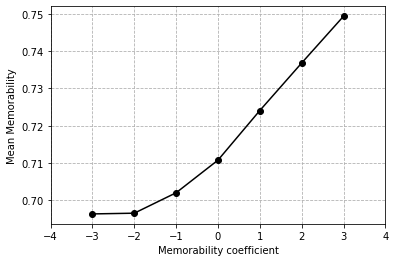

In [86]:
#layer_10

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_10_neg_3),np.mean(sq_layer_10_neg_2),np.mean(sq_layer_10_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_10_pos_1),np.mean(sq_layer_10_pos_2),np.mean(sq_layer_10_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [87]:
print(np.std(sq_layer_10_neg_3))
print(np.std(sq_layer_10_neg_2))
print(np.std(sq_layer_10_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_10_pos_1))
print(np.std(sq_layer_10_pos_2))
print(np.std(sq_layer_10_pos_3))

0.16066557
0.16233805
0.16477096
0.16730599
0.16935991
0.17103948
0.17256899


In [88]:
np.save('sq_layer_10_neg_3.npy',sq_layer_10_neg_3)
np.save('sq_layer_10_neg_2.npy',sq_layer_10_neg_2)
np.save('sq_layer_10_neg_1.npy',sq_layer_10_neg_1)
np.save('sq_layer_10_pos_1.npy',sq_layer_10_pos_1)
np.save('sq_layer_10_pos_2.npy',sq_layer_10_pos_2)
np.save('sq_layer_10_pos_3.npy',sq_layer_10_pos_3)

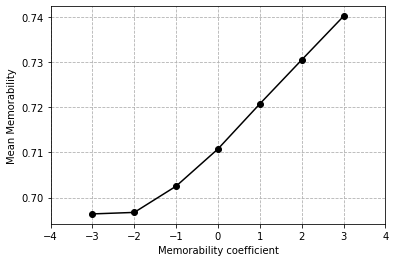

In [96]:
#layer_11

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(sq_layer_11_neg_3),np.mean(sq_layer_11_neg_2),np.mean(sq_layer_11_neg_1),np.mean(work_mem[:10000]),np.mean(sq_layer_11_pos_1),np.mean(sq_layer_11_pos_2),np.mean(sq_layer_11_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [97]:
print(np.std(sq_layer_11_neg_3))
print(np.std(sq_layer_11_neg_2))
print(np.std(sq_layer_11_neg_1))
print(np.std(work_mem[:10000]))
print(np.std(sq_layer_11_pos_1))
print(np.std(sq_layer_11_pos_2))
print(np.std(sq_layer_11_pos_3))

0.16016847
0.1624068
0.16532567
0.16730599
0.16918613
0.1704698
0.17141624


In [98]:
np.save('sq_layer_11_neg_3.npy',sq_layer_11_neg_3)
np.save('sq_layer_11_neg_2.npy',sq_layer_11_neg_2)
np.save('sq_layer_11_neg_1.npy',sq_layer_11_neg_1)
np.save('sq_layer_11_pos_1.npy',sq_layer_11_pos_1)
np.save('sq_layer_11_pos_2.npy',sq_layer_11_pos_2)
np.save('sq_layer_11_pos_3.npy',sq_layer_11_pos_3)

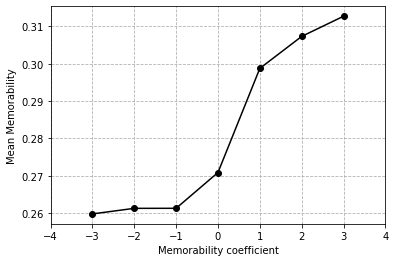

In [71]:
#layer_1

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_1_neg_3),np.mean(ov_layer_1_neg_2),np.mean(ov_layer_1_neg_1),np.mean(work_mem_oval[:3000]),np.mean(ov_layer_1_pos_1),np.mean(ov_layer_1_pos_2),np.mean(ov_layer_1_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


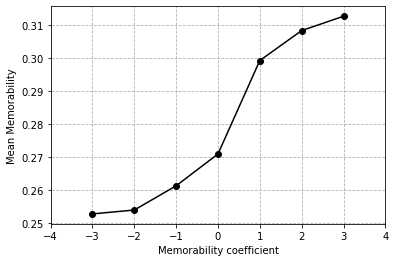

In [92]:
#layer_1

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_1_neg_3),np.mean(ov_layer_1_neg_2),np.mean(ov_layer_1_neg_1),np.mean(work_mem_oval[:3000]),np.mean(ov_layer_1_pos_1),np.mean(ov_layer_1_pos_2),np.mean(ov_layer_1_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()


In [93]:
np.save('ov_layer_1_neg_3.npy',ov_layer_1_neg_3)
np.save('ov_layer_1_neg_2.npy',ov_layer_1_neg_2)
np.save('ov_layer_1_neg_1.npy',ov_layer_1_neg_1)
np.save('ov_layer_1_pos_1.npy',ov_layer_1_pos_1)
np.save('ov_layer_1_pos_2.npy',ov_layer_1_pos_2)
np.save('ov_layer_1_pos_3.npy',ov_layer_1_pos_3)

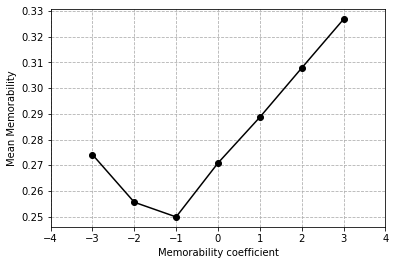

In [88]:
#layer_2

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_2_neg_3),np.mean(ov_layer_2_neg_2),np.mean(ov_layer_2_neg_1),np.mean(work_mem_oval[:3000]),np.mean(ov_layer_2_pos_1),np.mean(ov_layer_2_pos_2),np.mean(ov_layer_2_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

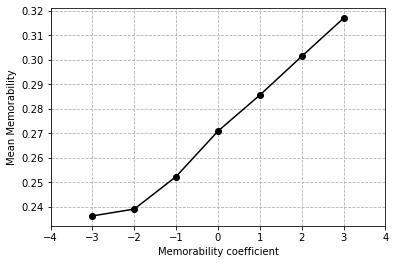

In [117]:
#layer_2

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_2_neg_3),np.mean(ov_layer_2_neg_2),np.mean(ov_layer_2_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_2_pos_1),np.mean(ov_layer_2_pos_2),np.mean(ov_layer_2_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [118]:
np.save('ov_layer_2_neg_3.npy',ov_layer_2_neg_3)
np.save('ov_layer_2_neg_2.npy',ov_layer_2_neg_2)
np.save('ov_layer_2_neg_1.npy',ov_layer_2_neg_1)
np.save('ov_layer_2_pos_1.npy',ov_layer_2_pos_1)
np.save('ov_layer_2_pos_2.npy',ov_layer_2_pos_2)
np.save('ov_layer_2_pos_3.npy',ov_layer_2_pos_3)

In [90]:
np.save('ov_layer_1_neg_3.npy',ov_layer_1_neg_3)
np.save('ov_layer_1_neg_2.npy',ov_layer_1_neg_2)
np.save('ov_layer_1_neg_1.npy',ov_layer_1_neg_1)
np.save('ov_layer_1_pos_1.npy',ov_layer_1_pos_1)
np.save('ov_layer_1_pos_2.npy',ov_layer_1_pos_2)
np.save('ov_layer_1_pos_3.npy',ov_layer_1_pos_3)

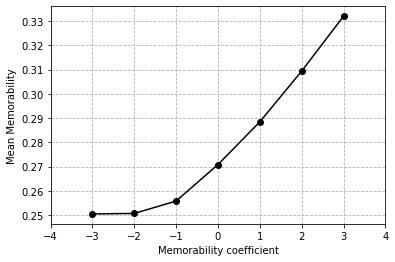

In [105]:
#layer_3

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_3_neg_3),np.mean(ov_layer_3_neg_2),np.mean(ov_layer_3_neg_1),np.mean(work_mem_oval[:3000]),np.mean(ov_layer_3_pos_1),np.mean(ov_layer_3_pos_2),np.mean(ov_layer_3_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

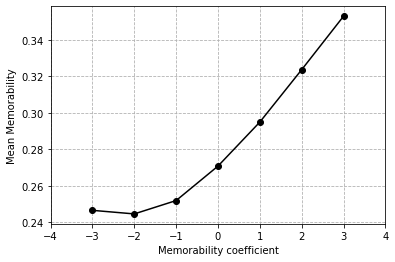

In [145]:
#layer_3

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_3_neg_3),np.mean(ov_layer_3_neg_2),np.mean(ov_layer_3_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_3_pos_1),np.mean(ov_layer_3_pos_2),np.mean(ov_layer_3_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [106]:
np.save('ov_layer_3_neg_3.npy',ov_layer_3_neg_3)
np.save('ov_layer_3_neg_2.npy',ov_layer_3_neg_2)
np.save('ov_layer_3_neg_1.npy',ov_layer_3_neg_1)
np.save('ov_layer_3_pos_1.npy',ov_layer_3_pos_1)
np.save('ov_layer_3_pos_2.npy',ov_layer_3_pos_2)
np.save('ov_layer_3_pos_3.npy',ov_layer_3_pos_3)

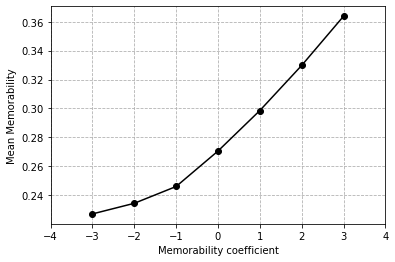

In [20]:
#layer_4

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_4_neg_3),np.mean(ov_layer_4_neg_2),np.mean(ov_layer_4_neg_1),np.mean(work_mem_oval[:2485]),np.mean(ov_layer_4_pos_1),np.mean(ov_layer_4_pos_2),np.mean(ov_layer_4_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

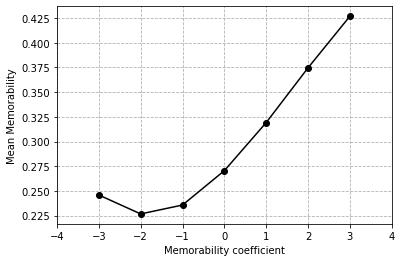

In [154]:
#layer_4

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_4_neg_3),np.mean(ov_layer_4_neg_2),np.mean(ov_layer_4_neg_1),np.mean(work_mem_oval[:2485]),np.mean(ov_layer_4_pos_1),np.mean(ov_layer_4_pos_2),np.mean(ov_layer_4_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [155]:
np.save('ov_layer_4_neg_3.npy',ov_layer_4_neg_3)
np.save('ov_layer_4_neg_2.npy',ov_layer_4_neg_2)
np.save('ov_layer_4_neg_1.npy',ov_layer_4_neg_1)
np.save('ov_layer_4_pos_1.npy',ov_layer_4_pos_1)
np.save('ov_layer_4_pos_2.npy',ov_layer_4_pos_2)
np.save('ov_layer_4_pos_3.npy',ov_layer_4_pos_3)

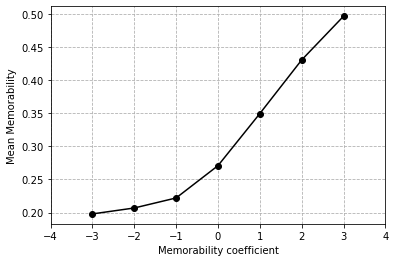

In [42]:
#layer_5

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_5_neg_3),np.mean(ov_layer_5_neg_2),np.mean(ov_layer_5_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_5_pos_1),np.mean(ov_layer_5_pos_2),np.mean(ov_layer_5_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

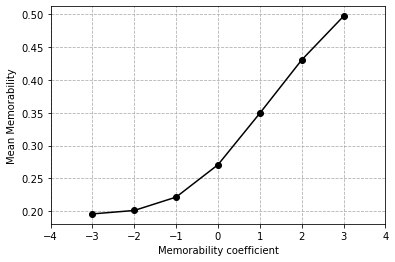

In [171]:
#layer_5

#font = {'fontname':'Times New Roman'}

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_5_neg_3),np.mean(ov_layer_5_neg_2),np.mean(ov_layer_5_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_5_pos_1),np.mean(ov_layer_5_pos_2),np.mean(ov_layer_5_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient', **font)
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability', **font)
plt.show()

In [172]:
np.save('ov_layer_5_neg_3.npy',ov_layer_5_neg_3)
np.save('ov_layer_5_neg_2.npy',ov_layer_5_neg_2)
np.save('ov_layer_5_neg_1.npy',ov_layer_5_neg_1)
np.save('ov_layer_5_pos_1.npy',ov_layer_5_pos_1)
np.save('ov_layer_5_pos_2.npy',ov_layer_5_pos_2)
np.save('ov_layer_5_pos_3.npy',ov_layer_5_pos_3)

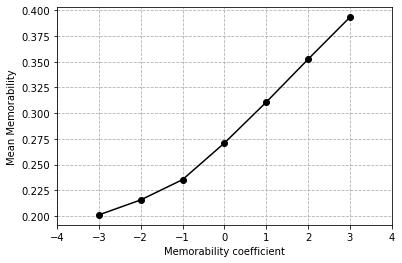

In [35]:
#layer_6

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_6_neg_3),np.mean(ov_layer_6_neg_2),np.mean(ov_layer_6_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_6_pos_1),np.mean(ov_layer_6_pos_2),np.mean(ov_layer_6_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

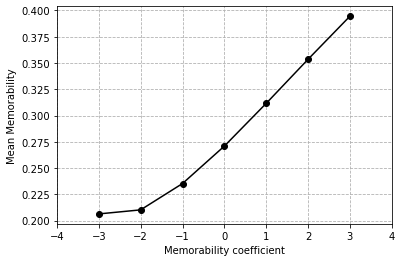

In [19]:
#layer_6

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_6_neg_3),np.mean(ov_layer_6_neg_2),np.mean(ov_layer_6_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_6_pos_1),np.mean(ov_layer_6_pos_2),np.mean(ov_layer_6_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [20]:
np.save('ov_layer_6_neg_3.npy',ov_layer_6_neg_3)
np.save('ov_layer_6_neg_2.npy',ov_layer_6_neg_2)
np.save('ov_layer_6_neg_1.npy',ov_layer_6_neg_1)
np.save('ov_layer_6_pos_1.npy',ov_layer_6_pos_1)
np.save('ov_layer_6_pos_2.npy',ov_layer_6_pos_2)
np.save('ov_layer_6_pos_3.npy',ov_layer_6_pos_3)

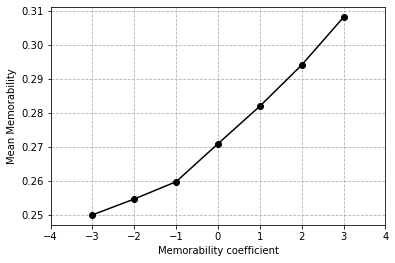

In [67]:
#layer_7

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_7_neg_3),np.mean(ov_layer_7_neg_2),np.mean(ov_layer_7_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_7_pos_1),np.mean(ov_layer_7_pos_2),np.mean(ov_layer_7_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

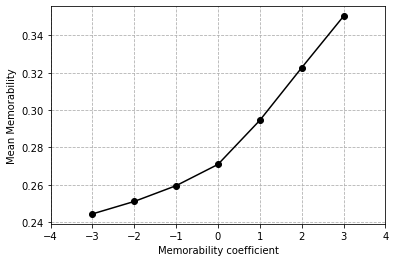

In [71]:
#layer_7

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_7_neg_3),np.mean(ov_layer_7_neg_2),np.mean(ov_layer_7_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_7_pos_1),np.mean(ov_layer_7_pos_2),np.mean(ov_layer_7_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [72]:
np.save('ov_layer_7_neg_3.npy',ov_layer_7_neg_3)
np.save('ov_layer_7_neg_2.npy',ov_layer_7_neg_2)
np.save('ov_layer_7_neg_1.npy',ov_layer_7_neg_1)
np.save('ov_layer_7_pos_1.npy',ov_layer_7_pos_1)
np.save('ov_layer_7_pos_2.npy',ov_layer_7_pos_2)
np.save('ov_layer_7_pos_3.npy',ov_layer_7_pos_3)

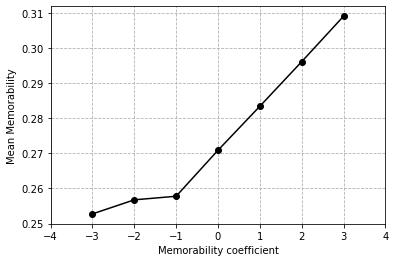

In [26]:
#layer_8

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_8_neg_3),np.mean(ov_layer_8_neg_2),np.mean(ov_layer_8_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_8_pos_1),np.mean(ov_layer_8_pos_2),np.mean(ov_layer_8_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

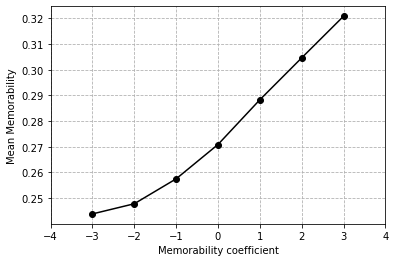

In [84]:
#layer_8

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_8_neg_3),np.mean(ov_layer_8_neg_2),np.mean(ov_layer_8_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_8_pos_1),np.mean(ov_layer_8_pos_2),np.mean(ov_layer_8_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [85]:
np.save('ov_layer_8_neg_3.npy',ov_layer_8_neg_3)
np.save('ov_layer_8_neg_2.npy',ov_layer_8_neg_2)
np.save('ov_layer_8_neg_1.npy',ov_layer_8_neg_1)
np.save('ov_layer_8_pos_1.npy',ov_layer_8_pos_1)
np.save('ov_layer_8_pos_2.npy',ov_layer_8_pos_2)
np.save('ov_layer_8_pos_3.npy',ov_layer_8_pos_3)

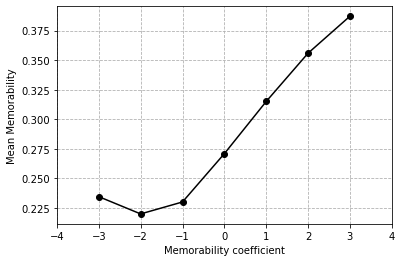

In [37]:
#layer_9

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_9_neg_3),np.mean(ov_layer_9_neg_2),np.mean(ov_layer_9_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_9_pos_1),np.mean(ov_layer_9_pos_2),np.mean(ov_layer_9_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

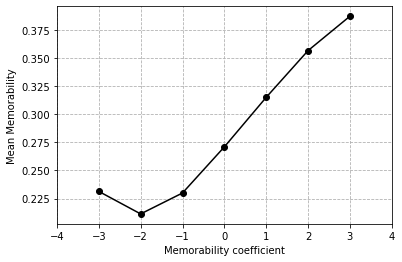

In [19]:
#layer_9

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_9_neg_3),np.mean(ov_layer_9_neg_2),np.mean(ov_layer_9_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_9_pos_1),np.mean(ov_layer_9_pos_2),np.mean(ov_layer_9_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [20]:
np.save('ov_layer_9_neg_3.npy',ov_layer_9_neg_3)
np.save('ov_layer_9_neg_2.npy',ov_layer_9_neg_2)
np.save('ov_layer_9_neg_1.npy',ov_layer_9_neg_1)
np.save('ov_layer_9_pos_1.npy',ov_layer_9_pos_1)
np.save('ov_layer_9_pos_2.npy',ov_layer_9_pos_2)
np.save('ov_layer_9_pos_3.npy',ov_layer_9_pos_3)

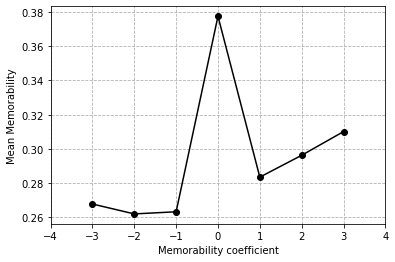

In [730]:
#layer_10

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_10_neg_3),np.mean(ov_layer_10_neg_2),np.mean(ov_layer_10_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_10_pos_1),np.mean(ov_layer_10_pos_2),np.mean(ov_layer_10_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [731]:
np.save('ov_layer_10_neg_3.npy',ov_layer_10_neg_3)
np.save('ov_layer_10_neg_2.npy',ov_layer_10_neg_2)
np.save('ov_layer_10_neg_1.npy',ov_layer_10_neg_1)
np.save('ov_layer_10_pos_1.npy',ov_layer_10_pos_1)
np.save('ov_layer_10_pos_2.npy',ov_layer_10_pos_2)
np.save('ov_layer_10_pos_3.npy',ov_layer_10_pos_3)

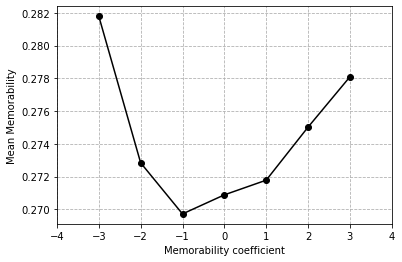

In [82]:
#layer_11

plt.plot([-3,-2,-1,0,1,2,3], [np.mean(ov_layer_11_neg_3),np.mean(ov_layer_11_neg_2),np.mean(ov_layer_11_neg_1),np.mean(work_mem_oval[:2500]),np.mean(ov_layer_11_pos_1),np.mean(ov_layer_11_pos_2),np.mean(ov_layer_11_pos_3)],marker='o',color='black')

plt.xlabel('Memorability coefficient')
plt.xlim((-4,+4))
#plt.ylim((0.1,0.7))
plt.grid(linestyle='--')
plt.ylabel('Mean Memorability')
plt.show()

In [83]:
np.save('ov_layer_11_neg_3.npy',ov_layer_11_neg_3)
np.save('ov_layer_11_neg_2.npy',ov_layer_11_neg_2)
np.save('ov_layer_11_neg_1.npy',ov_layer_11_neg_1)
np.save('ov_layer_11_pos_1.npy',ov_layer_11_pos_1)
np.save('ov_layer_11_pos_2.npy',ov_layer_11_pos_2)
np.save('ov_layer_11_pos_3.npy',ov_layer_11_pos_3)

In [99]:
print(np.mean(mem_neg_ov_9))
print(np.mean(mem_neg_ov_6))
print(np.mean(mem_neg_ov_3))
print(np.mean(work_mem_oval[:10000]))
print(np.mean(mem_pos_ov_3))
print(np.mean(mem_pos_ov_6))
print(np.mean(mem_pos_ov_9))

0.16413482
0.18907763
0.22559385
0.27281466
0.34536672
0.42453068
0.5011299


## Finding the separating hyperplanes

### Non-oval Face - Assessor 1 - 18 * 512

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_1, test_size=0.1, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

In [347]:
from sklearn import metrics

pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

Accuracy: 0.7933


In [348]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

Accuracy: 0.797


In [349]:
w = clf.coef_[0]
np.save('w_aug_ass1_sq.npy', w)

### Oval Face - Assessor 1 - 18* 512

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_1_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

In [351]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

Accuracy: 0.813


In [352]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

Accuracy: 0.8149888888888889


In [353]:
w = clf.coef_[0]
np.save('w_aug_ass1_ov.npy', w)

### Non-oval Face - Assessor 2 - 18 * 512

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_2, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.8291
[[4094  852]
 [ 857 4197]]


<AxesSubplot:>

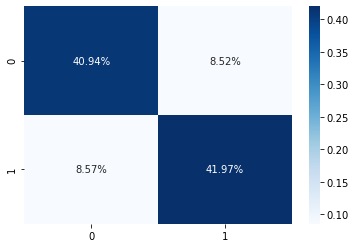

In [362]:
from sklearn.metrics import confusion_matrix

pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8390222222222222
[[37982  7072]
 [ 7416 37530]]


<AxesSubplot:>

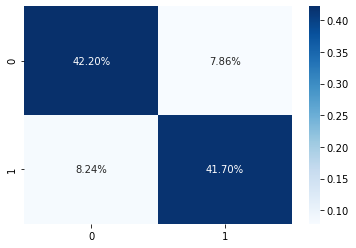

In [363]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [364]:
w = clf.coef_[0]
np.save('w_aug_ass2_sq.npy', w)

### Oval Face - Assessor 2 - 18 * 512

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_2_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.8157
[[4095  891]
 [ 952 4062]]


<AxesSubplot:>

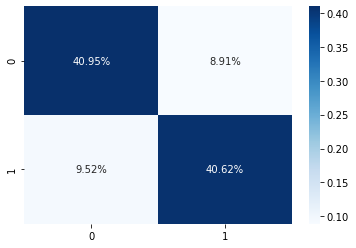

In [358]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8202777777777778
[[37327  7686]
 [ 8489 36498]]


<AxesSubplot:>

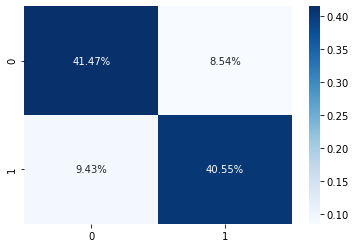

In [359]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [360]:
w = clf.coef_[0]
np.save('w_aug_ass2_ov.npy', w)

### Non-oval Face - Assessor 3 - 18 * 512

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_3, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.8037
[[4001  922]
 [1041 4036]]


<AxesSubplot:>

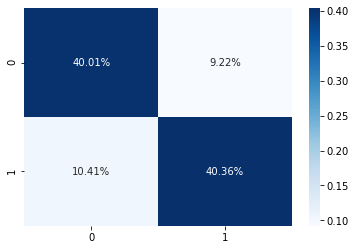

In [366]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8105444444444444
[[36879  8198]
 [ 8853 36070]]


<AxesSubplot:>

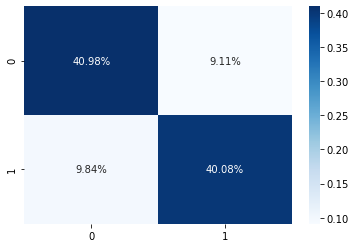

In [367]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [368]:
w = clf.coef_[0]
np.save('w_aug_ass3_sq.npy', w)

### Oval Face - Assessor 3 - 18 * 512

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_3_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.7903
[[3985  969]
 [1128 3918]]


<AxesSubplot:>

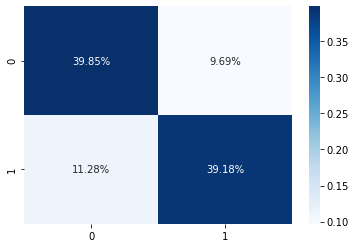

In [370]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7938222222222222
[[36300  8746]
 [ 9810 35144]]


<AxesSubplot:>

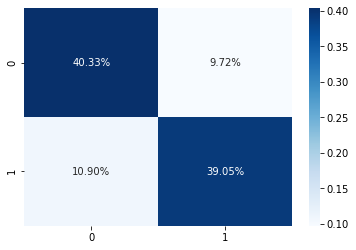

In [371]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [372]:
w = clf.coef_[0]
np.save('w_aug_ass3_ov.npy', w)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_3_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.697
[[4157 1313]
 [1717 2813]]


<AxesSubplot:>

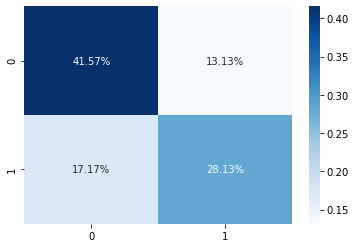

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns


pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

### Non-oval Face - Assessor 1 - 1 * 512

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_1, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.6859
[[3436 1532]
 [1609 3423]]


<AxesSubplot:>

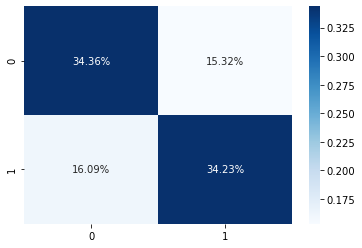

In [375]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.6947444444444445
[[31271 13761]
 [13712 31256]]


<AxesSubplot:>

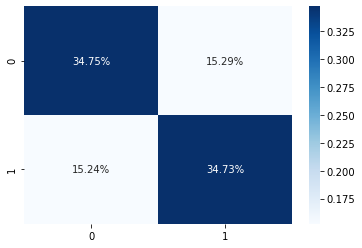

In [376]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

### Oval Face - Assessor 1 - 1 * 512

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_3_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.6886
[[3430 1524]
 [1590 3456]]


<AxesSubplot:>

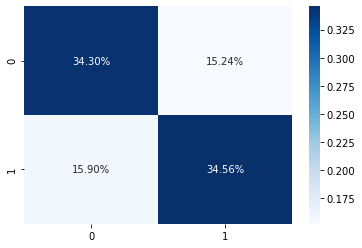

In [44]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7030333333333333
[[31677 13360]
 [13367 31596]]


<AxesSubplot:>

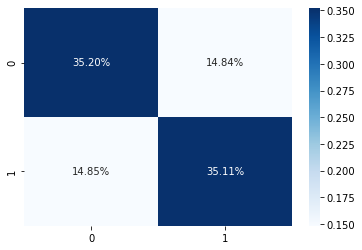

In [379]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [32]:
mean_1 = np.median(mems_1)
mean_2 = np.median(mems_2)
mean_3 = np.median(mems_3)
mean_1_oval = np.median(mems_1_oval)
mean_2_oval = np.median(mems_2_oval)
mean_3_oval = np.median(mems_3_oval)

y_1 = np.ones_like(mems_1)
y_1[mems_1<mean_1] = 0
y_2 = np.ones_like(mems_2)
y_2[mems_2<mean_2] = 0
y_3 = np.ones_like(mems_3)
y_3[mems_3<mean_3] = 0
y_1_oval = np.ones_like(mems_1_oval)
y_1_oval[mems_1_oval<mean_1_oval] = 0
y_2_oval = np.ones_like(mems_2_oval)
y_2_oval[mems_2_oval<mean_2_oval] = 0
y_3_oval = np.ones_like(mems_3_oval)
y_3_oval[mems_3_oval<mean_3_oval] = 0

## This time using mean instead of median

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_3_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.697
[[4157 1313]
 [1717 2813]]


<AxesSubplot:>

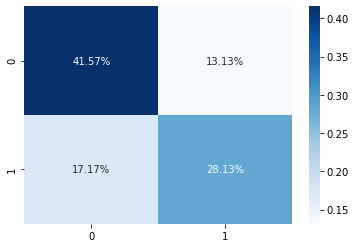

In [144]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7383222222222222
[[38963 10625]
 [12926 27486]]


<AxesSubplot:>

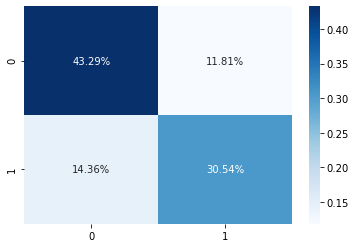

In [129]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [145]:
w = clf.coef_[0]
w = w/np.linalg.norm(w)

#np.save('w_512_sq_senet.npy',w)
#0.73

#np.save('w_512_sq_resnet.npy',w)
#0.68

#np.save('w_512_sq_vgg.npy',w)
#0.70

#np.save('w_512_ov_resnet.npy',w)
#0.70

#np.save('w_512_ov_senet.npy',w)
#0.69

#np.save('w_512_ov_vgg.npy',w)
#0.69

### Non-oval Face - Assessor 1 - 18 * 512 (mean)

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_1, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.7928
[[3775 1035]
 [1037 4153]]


<AxesSubplot:>

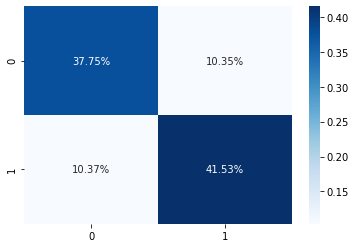

In [382]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7981555555555555
[[34011  9489]
 [ 8677 37823]]


<AxesSubplot:>

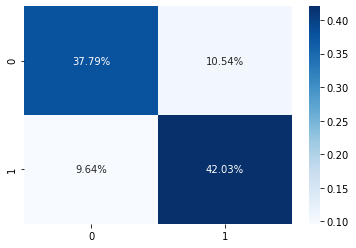

In [383]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [384]:
w = clf.coef_[0]
np.save('w_aug_ass1_sq_mean.npy', w)

### Oval Face - Assessor 1 - 18 * 512 (mean)

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_1_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.8149
[[4625  844]
 [1007 3524]]


<AxesSubplot:>

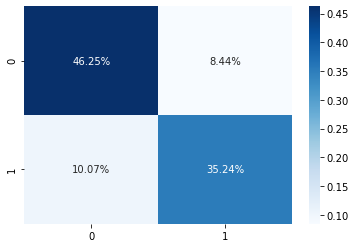

In [391]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8198777777777778
[[42030  7218]
 [ 8993 31759]]


<AxesSubplot:>

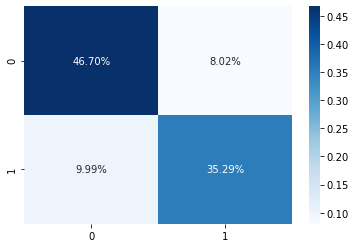

In [392]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [393]:
w = clf.coef_[0]
np.save('w_aug_ass1_ov_mean.npy', w)

### Non-oval Face - Assessor 2 - 18 * 512 (mean)

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_2, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.8317
[[4679  811]
 [ 872 3638]]


<AxesSubplot:>

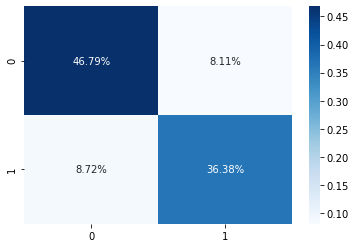

In [395]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8422555555555555
[[42985  6603]
 [ 7594 32818]]


<AxesSubplot:>

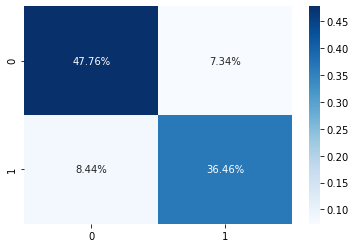

In [396]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [397]:
w = clf.coef_[0]
np.save('w_aug_ass2_sq_mean.npy', w)

### Oval Face - Assessor 2 - 18 * 512 (mean)

In [18]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_2_oval, test_size=0.1, random_state=42)
#clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.8207
[[4672  814]
 [ 979 3535]]


<AxesSubplot:>

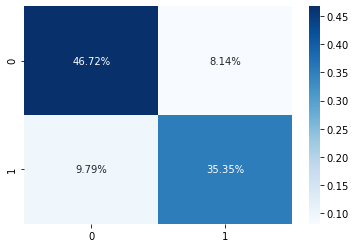

In [402]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8242333333333334
[[42174  7107]
 [ 8712 32007]]


<AxesSubplot:>

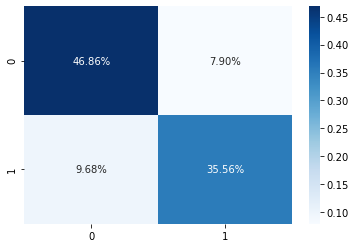

In [403]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [404]:
w = clf.coef_[0]
np.save('w_aug_ass2_ov_mean.npy', w)

### Non-oval Face - Assessor 3 - 18 * 512 (mean)

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_3, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.807
[[4514  845]
 [1085 3556]]


<AxesSubplot:>

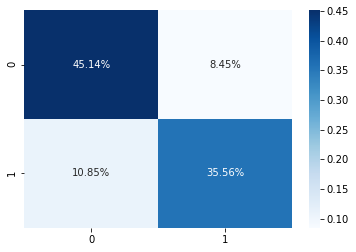

In [406]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8149111111111111
[[41307  7622]
 [ 9036 32035]]


<AxesSubplot:>

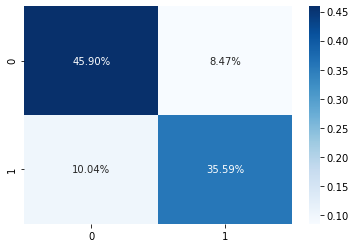

In [407]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [408]:
w = clf.coef_[0]
np.save('w_aug_ass3_sq_mean.npy', w)

### Oval Face - Assessor 3 - 18 * 512 (mean)

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_3_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.7952
[[4607  863]
 [1185 3345]]


<AxesSubplot:>

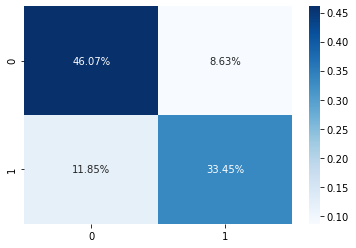

In [410]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.8011666666666667
[[41895  7778]
 [10117 30210]]


<AxesSubplot:>

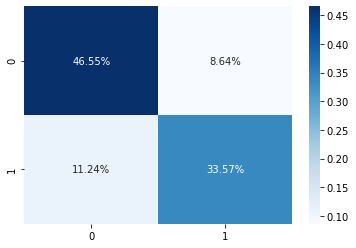

In [411]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [412]:
w = clf.coef_[0]
np.save('w_aug_ass3_ov_mean.npy', w)

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_1_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.7063
[[4119 1350]
 [1587 2944]]


<AxesSubplot:>

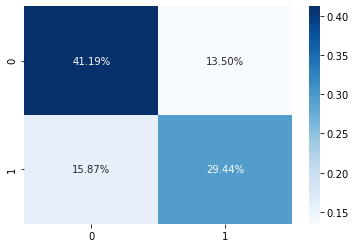

In [414]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7113888888888888
[[37703 11545]
 [14430 26322]]


<AxesSubplot:>

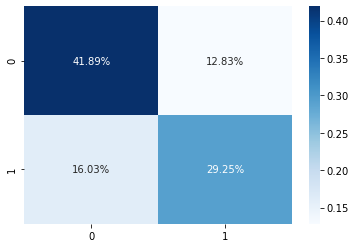

In [415]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_1, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.683
[[3179 1631]
 [1539 3651]]


<AxesSubplot:>

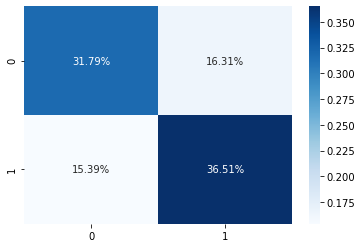

In [417]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.6959222222222222
[[29253 14247]
 [13120 33380]]


<AxesSubplot:>

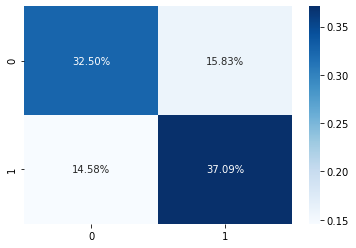

In [418]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_2, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.7333
[[4290 1200]
 [1467 3043]]


<AxesSubplot:>

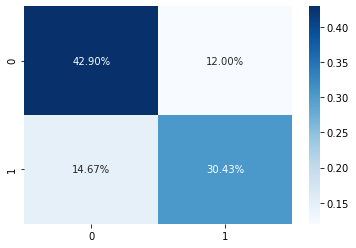

In [420]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7383222222222222
[[38963 10625]
 [12926 27486]]


<AxesSubplot:>

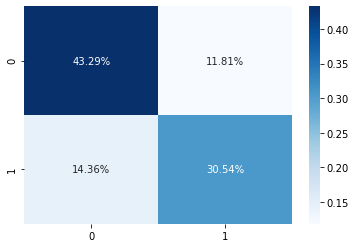

In [421]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_2_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.6949
[[4125 1361]
 [1690 2824]]


<AxesSubplot:>

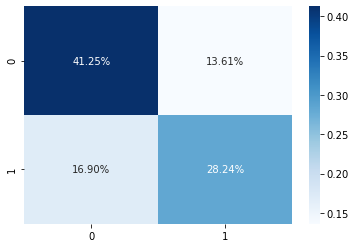

In [423]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7039666666666666
[[37457 11824]
 [14819 25900]]


<AxesSubplot:>

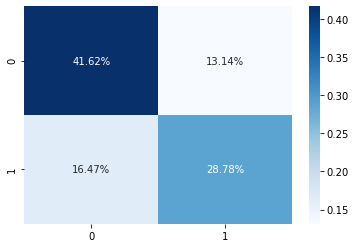

In [424]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_3, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.7054
[[4077 1282]
 [1664 2977]]


<AxesSubplot:>

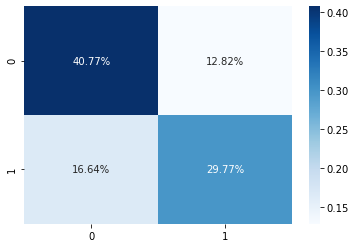

In [426]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7076333333333333
[[37082 11847]
 [14466 26605]]


<AxesSubplot:>

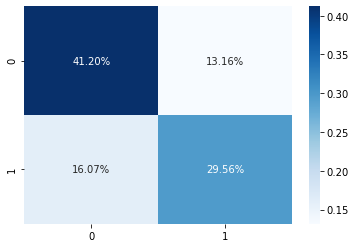

In [427]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
X_train, X_test, y_train_1, y_test_1 = train_test_split(lats, y_3_oval, test_size=0.1, random_state=42)
clf = LogisticRegression(max_iter=4000, verbose=1).fit(X_train, y_train_1)

Accuracy: 0.697
[[4157 1313]
 [1717 2813]]


<AxesSubplot:>

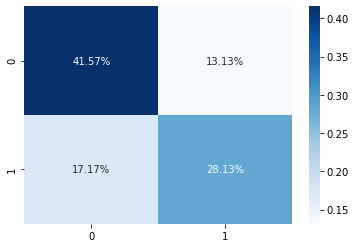

In [429]:
pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test_1, pred))

cf_matrix = confusion_matrix(y_test_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Accuracy: 0.7041555555555555
[[38089 11584]
 [15042 25285]]


<AxesSubplot:>

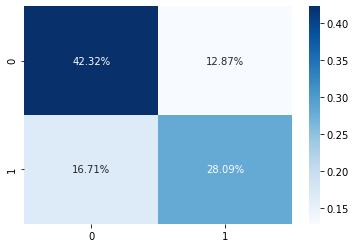

In [430]:
pred = clf.predict(X_train)
print("Accuracy:",metrics.accuracy_score(y_train_1, pred))

cf_matrix = confusion_matrix(y_train_1, pred)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [64]:
#Loading age and smile hyperplane for conditionally modifying the memorability score

age = np.load("age.npy")
smile = np.load("smile.npy")

In [67]:
age = age.reshape(-1,1)
smile = smile.reshape(-1,1)
age.shape

(9216, 1)

In [65]:
age = age/np.linalg.norm(age)
smile = smile/np.linalg.norm(smile)

In [31]:
age = np.ravel(age)
smile = np.ravel(smile)
age.shape

(9216,)

In [79]:
cond_age = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,age)[0][0])*age)
print(cond_age.shape)
cond_smile = w_sq - np.ravel((np.dot(w_sq.reshape(-1,1).T,smile)[0][0])*smile)
print(cond_smile.shape)

(9216,)
(9216,)


[0.5288919]


(-0.5, 1023.5, 1023.5, -0.5)

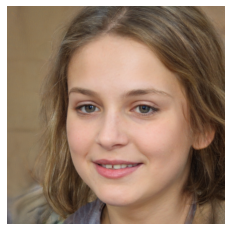

In [128]:
x = X_train[341].copy()
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

[0.7205371]


(-0.5, 1023.5, 1023.5, -0.5)

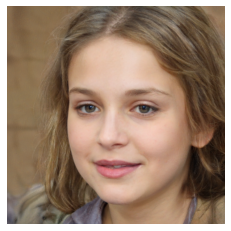

In [132]:
x = X_train[341].copy() + 3 * cond_age
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_1, y_test_1 = train_test_split(mems_aug_style2, y_2_oval, test_size=0.1, random_state=42)

## Modifying memorability score (Square-shaped)

[0.40044266]


(-0.5, 1023.5, 1023.5, -0.5)

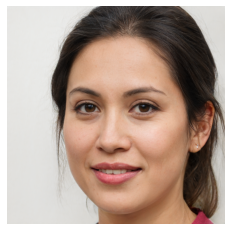

In [48]:
x = np.ravel(X_test[161])
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

[0.5416969]


(-0.5, 1023.5, 1023.5, -0.5)

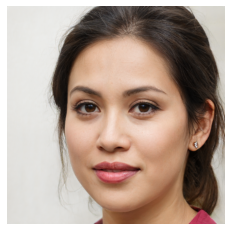

In [49]:
x = np.ravel(X_test[161]) +5* w_sq
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
#img = load_image(img)
plt.imshow(img)
plt.axis('off')

## Modifying memorability score (Oval-shaped)

[0.33154583]


(-0.5, 192.5, 255.5, -0.5)

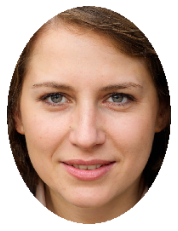

In [52]:
x = np.ravel(X_test[401]) 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(calc_mem_ov(x))
#print(calc_mem(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

[0.6750016]


(-0.5, 196.5, 255.5, -0.5)

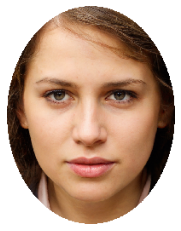

In [54]:
x = np.ravel(X_test[401]) + 6 * w_ov
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem_ov(x))
#print(calc_mem(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

## Using w from SVM

In [55]:
w_svm = np.load('w2_oval_svm.npy')
w_svm = w_svm/np.linalg.norm(w_svm)

[0.33565155]


(-0.5, 197.5, 255.5, -0.5)

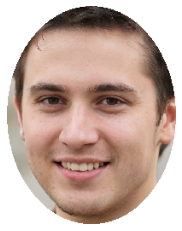

In [57]:
x = X_test[65].copy() 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(calc_mem_ov(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

[0.51109123]


(-0.5, 201.5, 255.5, -0.5)

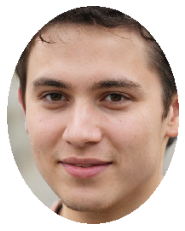

In [60]:
x = np.ravel(X_test[65]) + 3* np.ravel(w_svm)
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem_ov(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

## Morphing

In [159]:
first_pcs = []
sec_pcs = []

In [111]:
lats = np.load('lats_512_style2.npy')
print(lats.shape)

(100000, 1, 512)


In [113]:
lats = lats.reshape((-1,512))
print(lats.shape)

(100000, 512)


[0.23153985]
[0.31676883]


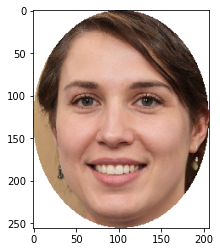

In [22]:
x = X_train[0].copy() 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(x)
print(calc_mem(x))
#img = load_image(img)
plt.imshow(oval)

[0.42361456]
[0.5600296]


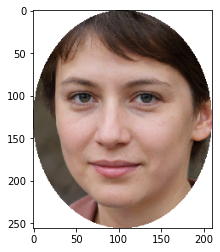

In [42]:
x = X_train[9654].copy() 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(x)
print(calc_mem(x))
#img = load_image(img)
plt.imshow(oval)

In [20]:
w = np.load('w_aug_ass2_ov_mean.npy')
w = w / np.linalg.norm(w)

2.6289763709312934


In [43]:
x1 = X_train[9654].copy() 
x2 = X_train[0].copy() 
diff = x2 - x1

[0.25274348]
[0.34362304]


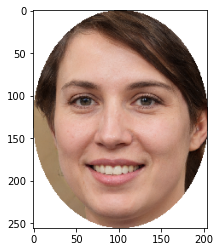

In [47]:
x = x1 + (4/5) * diff
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(x)
print(calc_mem(x))
#img = load_image(img)
plt.imshow(oval)

In [116]:
features = lats.T
cov_mat = np.cov(features)

In [117]:
values, vectors = np.linalg.eig(cov_mat)

In [118]:
print(cov_mat.shape)
print(vectors.shape)

(512, 512)
(512, 512)


[0.653591]
[0.8512926]


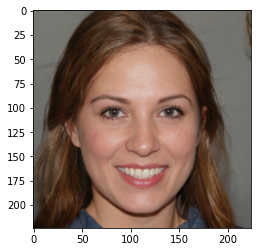

In [607]:
x = mems_aug_style2[15600].copy() 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
#oval = ovalize_new(img)
#oval = np.array(oval)
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(x)
print(calc_mem(x))
#img = load_image(img)
plt.imshow(sample[0])

In [565]:
j = 7
alpha = vectors[j]/np.linalg.norm(vectors[j])

In [599]:
alpha =0.5*vectors[2]/np.linalg.norm(vectors[2]) + 10 * vectors[3]/np.linalg.norm(vectors[3]) + 2*vectors[6]/np.linalg.norm(vectors[6]) +2*vectors[7]/np.linalg.norm(vectors[7]) -0.5* vectors[8]/np.linalg.norm(vectors[8]) -6* vectors[4]/np.linalg.norm(vectors[4])
    
alpha = alpha/np.linalg.norm(alpha)
print(np.dot(w_sq, alpha))

0.02243436668524791


In [351]:
alpha = 0
j = 0
k = 9
for i in range(j,k):
    alpha = alpha + vectors[i]
alpha = alpha/np.linalg.norm(alpha)

In [624]:
y = w_sq.reshape((1,9216))
y = np.repeat(y[np.newaxis,...], 20, axis=0)
print(y.shape)

(20, 1, 9216)


In [ ]:
scalars = np.linalg.solve(vectors, w_sq.reshape((1,9216)) )

In [170]:
in_dot = []
#vectors = np.real(vectors)
for i in range(20):
    for j in range(i,20):
        alpha = 0
        for k in range(i,j+1):
            alpha = alpha + vectors[k]
        in_dot.append(np.dot(w_sq, alpha/np.linalg.norm(alpha)))

print(np.max(in_dot))
print(np.min(in_dot))


0.07146642484619084
-0.086585321126946


In [470]:
w = np.load('w')

In [53]:
all_v = np.sum(values)

In [146]:
inner_dot_ov = []
inner_dot_sq = []
w_ov = np.load('w_512_ov_senet.npy')
w_sq = np.load('w_512_sq_senet.npy')
for i in range(512):
    alpha = vectors[i]/np.linalg.norm(vectors[i])
    inner_dot_ov.append(np.dot(w_ov, alpha))
    inner_dot_sq.append(np.dot(w_sq, alpha))
print(max(inner_dot_ov))
print(max(inner_dot_sq))

0.12526251100060248
0.16205049917222314


In [148]:
print(inner_dot_ov[:20])
print(inner_dot_sq[:20])

[0.0027551666664097276, -0.035033459909828285, 0.013710839000785555, 0.029516282993492925, 0.05511743991822052, 0.0648769872609721, -0.010885657934245403, 0.005841938607735249, 0.034408795243183826, -0.0005635244475521162, 0.03664928003990856, 0.04049529244088011, -0.029825886462697127, 0.005052916730164135, -0.020586741554293818, -0.023048288801995026, -0.008875466942784216, -0.00817436027490108, -0.052669322737569524, 0.05169362768382997]
[-0.011009916495406558, -0.013355393633327063, 0.028399356900966212, 0.07146642484619084, 0.014822734343657294, -0.04058878157435602, 0.007862505193387586, -0.006211144853808213, 0.0325639580123204, 0.01091257721101277, 0.017803340719129278, -0.015248364763617225, -0.05123221683976187, 0.04389974531530261, 0.0020662337933615334, -0.0049421115712420865, -0.0348432840662593, -0.0386498851738312, -0.07647700614146444, 0.06276346636676858]


[0.45679963]


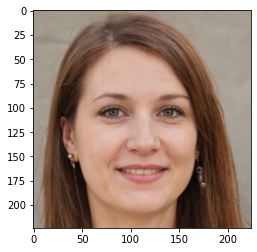

In [154]:
z = lats[0]
z = z.reshape((1,512))
#z = np.random.rand(1,512)
dlatents = generator.mapping_network(z)
dlatents = w_average + (dlatents - w_average) * 0.5
out = generator.synthesis_network(dlatents)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(x)
#print(calc_mem(x))
#img = load_image(img)
plt.imshow(sample[0])

In [155]:
j = 3

alpha = vectors[j]/np.linalg.norm(vectors[j])

[0.15017012]


(-0.5, 223.5, 223.5, -0.5)

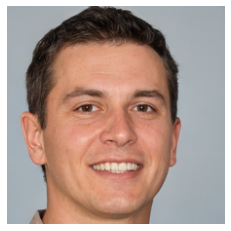

In [1070]:
z = lats[445] -2.2* ww
z = z.reshape((1,512))
#z = np.random.rand(1,512)
dlatents = generator.mapping_network(z)
dlatents = w_average + (dlatents - w_average) * 0.5
out = generator.synthesis_network(dlatents)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(calc_mem(x))
#print(calc_mem(x))
#img = load_image(img)
plt.imshow(sample[0])
plt.axis('off')

In [150]:
print(np.argmin(inner_dot_ov))
print(np.argmin(inner_dot_sq))

492
93


In [167]:
ind_max = np.argpartition(np.ravel(mems_2_oval), -10000)[-10000:]
ind_min = np.argpartition(np.ravel(mems_2_oval), 10000)[:10000]

In [168]:
lat_10_max = mems_aug_style2[ind_max]
mem_10_max = mems_2_oval[ind_max]
lat_10_min = mems_aug_style2[ind_min]
mem_10_min = mems_2_oval[ind_min]

In [169]:
lat_10 = np.vstack((lat_10_min,lat_10_max))
mem_10 = np.vstack((mem_10_min, mem_10_max))
print(lat_10.shape)
print(mem_10.shape)

(20000, 9216)
(20000, 1)


In [960]:
ww= np.load('w_512_sq_senet.npy')
ww = ww/np.linalg.norm(ww)

In [961]:
lats.shape

(100000, 512)

In [170]:
features = lat_10.T
cov_mat = np.cov(features)

In [171]:
values, vectors = np.linalg.eig(cov_mat)

In [165]:
first_pcs = vectors[:20]

In [166]:
first_pcs[0].shape

(9216,)

In [172]:
sec_pcs = vectors[:20]

In [173]:
all_dots = []
for i in range(20):
    for j in range(20):
        all_dots.append(np.dot(first_pcs[i],sec_pcs[j]))

print(min(all_dots))

(-0.35200291524747035+0.0436613678768489j)


In [175]:
all_dots = np.real(all_dots)

In [176]:
all_dots = [x**2 for x in all_dots]
print(min(all_dots))

7.508431541448315e-09


In [ ]:
ind_min = np.argpartition(np.ravel(all_dots), 20)[:20]
print(all_dots[ind_min])

In [188]:
all_dots[37]

2.2985048358759392e-07

In [181]:
ind_min

array([297,  31,  37, 240,  13, 320, 314,  52, 110, 112, 307, 234,  40,
       123, 354,  60, 340, 360,  17, 277])

In [225]:
all_v = np.sum(values)

In [217]:
explained = 0

for i in range(150):
    explained = explained + (values[i]/all_v)
print(explained)

(0.9060229500661785+0j)


In [226]:
real_v = np.real(values)
all_v = np.real(all_v)

In [227]:
vectors = np.real(vectors)

[0.2615329]
[0.35475478]


(-0.5, 202.5, 255.5, -0.5)

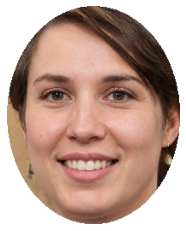

In [204]:
x = X_train[0].copy() 
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
print(x)
print(calc_mem(x))
#print(assessor_1.predict(sample)[0])
#print(assessor_3.predict(sample)[0])
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

[0.1865294]
[0.25976354]


(-0.5, 205.5, 255.5, -0.5)

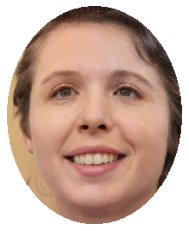

In [300]:
x = X_train[0]- 90* alpha
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(x)
print(calc_mem(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

### Modifying real faces memorability

In [194]:
lat1 = np.load("generated_images_tiled/Gabriel_Attal_02_(cropped)_01.npy")
lat2 = np.load("generated_images_no_tiled/Gabriel_Attal_02_(cropped)_01.npy")

print(lat1.shape)
print(lat2.shape)

(18, 512)
(18, 512)


[0.25185615]


(-0.5, 1023.5, 1023.5, -0.5)

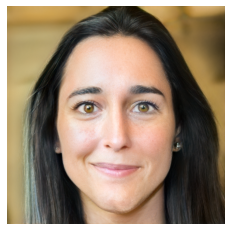

In [189]:
x = np.ravel(lat2)
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

[0.18344314]


(-0.5, 1023.5, 1023.5, -0.5)

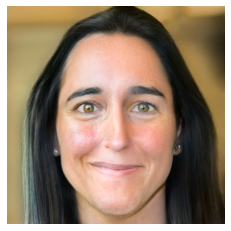

In [193]:
x = np.ravel(lat2) - 25 * w_sq
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
sample = load_image(img)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
print(calc_mem(x))
plt.imshow(img)
plt.axis('off')

[0.3868472]


(-0.5, 191.5, 255.5, -0.5)

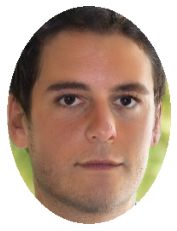

In [195]:
x = np.ravel(lat2)
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
#print(x)
print(calc_mem_ov(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')

[0.29841223]


(-0.5, 193.5, 255.5, -0.5)

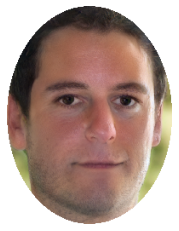

In [216]:
x = np.ravel(lat2)-  21* w_ov
x = x.reshape((1,18,512))
out = generator.synthesis_network(x)
img = convert_images_to_uint8(out, nchw_to_nhwc=True, uint8_cast=True)
img = img.numpy()[0]
oval = ovalize_new(img)
oval = np.array(oval)
sample = load_image(oval)
sample = sample.reshape((1,224,224,3))
x = assessor_2.predict(sample)[0]
#print(assessor_3.predict(sample)[0])
#print(x)
print(calc_mem_ov(x))
#img = load_image(img)
plt.imshow(oval)
plt.axis('off')